In [1]:
import os
import opyplus as op
import matplotlib.pyplot as plt
import pandas as pd
data_path = "../../data/sinergym/"
epw_files = os.listdir(data_path)
weather_dfs = []
base_df = None
for file in epw_files:
    # load weather data object
    try:
        if "USA" in file:
            weather_data = op.WeatherData.from_epw(os.path.join(data_path, file))
            weather_dfs.append(weather_data.get_weather_series())
            if file == 'USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw':#'USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw':
            #if file == "USA_AZ_Tucson-Davis-Monthan.AFB.722745_TMYx.2007-2021.epw":
                base_df = weather_dfs[-1]
    except Exception as e:
        print(e)

In [2]:
big_df = pd.concat(weather_dfs)
#variables = ['drybulb', 'relhum', "winddir", "dirnorrad", "difhorrad", "windspd", "precip_wtr", "snowdepth"]
variables = ['drybulb', 'relhum', "winddir", "dirnorrad", "windspd"]

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

def calculate_deviations(base_df, variable, n):
    base_df_cpy = base_df[variable]
    moving_avg = base_df_cpy.rolling(n).mean()
    return base_df_cpy.iloc[n:] - moving_avg.iloc[n:]

def split_data(deviations):
    num_train = int(0.8 * len(deviations))
    train_X = np.array(deviations.iloc[:num_train]).reshape([-1, 1])
    train_Y = np.array(deviations.iloc[1:num_train + 1]).reshape([-1, 1])
    eval_X = np.array(deviations.iloc[num_train:-1]).reshape([-1, 1])
    eval_Y = np.array(deviations.iloc[num_train+1:]).reshape([-1, 1])
    return train_X, train_Y, eval_X, eval_Y

def normalize_data(train_X, train_Y, eval_X, eval_Y):
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    train_X = scaler_X.fit_transform(train_X)
    train_Y = scaler_Y.fit_transform(train_Y)
    eval_X = scaler_X.transform(eval_X)
    eval_Y = scaler_Y.transform(eval_Y)
    return train_X, train_Y, eval_X, eval_Y, scaler_X, scaler_Y

def train_and_evaluate(train_X, train_Y, eval_X, eval_Y):
    reg = LinearRegression()
    reg.fit(train_X, train_Y)
    score = reg.score(eval_X, eval_Y)
    return reg, score

def calculate_parameters(reg, deviations, scaler_x, scaler_y):
    coef = reg.coef_.squeeze().item()
    intercept = reg.intercept_.squeeze().item()
    dt = 1 / len(deviations)
    tau = dt / (1 - coef)
    mu = intercept * tau / dt # intercept = mu * dt / tau
    scaler_y.inverse_transform(np.array([[mu]]))[0][0]
    return mu, tau, dt

def calculate_sigma(reg, train_X, train_Y, tau, scaler_x, scaler_y):
    preds = scaler_y.inverse_transform(reg.predict(train_X))
    targets = scaler_y.inverse_transform(train_Y)
    
    std = np.sqrt(np.mean((preds - targets) ** 2))
    sigma = std / (np.sqrt(dt * 2. / tau))
    return sigma

n = 168
base_OU_params = {}
for variable in variables:
    deviations = calculate_deviations(base_df, variable, n)
    print(deviations)
    
    train_X, train_Y, eval_X, eval_Y = split_data(deviations)
    train_X, train_Y, eval_X, eval_Y, scaler_X, scaler_Y = normalize_data(train_X, train_Y, eval_X, eval_Y)
    reg, score = train_and_evaluate(train_X, train_Y, eval_X, eval_Y)
    print("SCORE IS: ", score)
    
    
    mu, tau, dt = calculate_parameters(reg, deviations, scaler_X, scaler_Y)
    sigma = calculate_sigma(reg, train_X, train_Y, tau, scaler_X, scaler_Y)
    print(mu, sigma, tau)
    base_OU_params[variable] = (sigma, mu, tau)
base_OU_params = pd.DataFrame.from_dict(base_OU_params)


168     3.808929
169     3.729167
170     3.644048
171     2.555952
172     2.461905
          ...   
8755    2.716667
8756    1.692857
8757   -0.319048
8758    0.657143
8759    2.627381
Name: drybulb, Length: 8592, dtype: float64
SCORE IS:  0.9162951966869103
5.354165991418429e-16 5.531731866128253 0.0025503494379979213
168     13.285714
169     13.339286
170      9.452381
171     16.559524
172     16.690476
          ...    
8755   -10.642857
8756    -8.601190
8757    -5.577381
8758    -7.529762
8759   -10.494048
Name: relhum, Length: 8592, dtype: float64
SCORE IS:  0.9394949880247473
7.655758290299035e-16 17.312887196077604 0.0023171275985263765
168     -76.130952
169     -75.357143
170     -64.940476
171      -4.940476
172      -4.523810
           ...    
8755     31.309524
8756    110.416667
8757    -39.642857
8758    -69.583333
8759    -29.702381
Name: winddir, Length: 8592, dtype: float64
SCORE IS:  0.45223292600832365
2.247335012962023e-18 73.99846538345739 0.00040229801291031

In [4]:
base_df[1000:]

,year,month,day,hour,minute,datasource,drybulb,dewpoint,relhum,atmos_pressure,...,ceiling_hgt,presweathobs,presweathcodes,precip_wtr,aerosol_opt_depth,snowdepth,days_last_snow,Albedo,liq_precip_depth,liq_precip_rate
1000,2005,2,11,17,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,14.0,12.0,88.0,91700.0,...,720.0,NaN,,240.0,0.037,0.0,88.0,0.2,3.0,6.0
1001,2005,2,11,18,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,14.0,13.0,94.0,91700.0,...,1050.0,NaN,,240.0,0.037,0.0,88.0,0.2,NaN,NaN
1002,2005,2,11,19,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,14.0,13.0,94.0,91700.0,...,1410.0,NaN,,240.0,0.037,0.0,88.0,0.2,NaN,NaN
1003,2005,2,11,20,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,14.0,14.0,100.0,91700.0,...,1410.0,NaN,,240.0,0.037,0.0,88.0,0.2,NaN,NaN
1004,2005,2,11,21,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,14.0,14.0,100.0,91700.0,...,1410.0,NaN,,229.0,0.037,0.0,88.0,0.2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2005,12,31,20,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,16.0,-5.0,22.0,91800.0,...,7500.0,NaN,,150.0,0.039,0.0,88.0,0.2,NaN,NaN
8756,2005,12,31,21,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,15.0,-5.0,24.0,91800.0,...,7500.0,NaN,,150.0,0.039,0.0,88.0,0.2,NaN,NaN
8757,2005,12,31,22,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,13.0,-5.0,27.0,91700.0,...,7500.0,NaN,,150.0,0.039,0.0,88.0,0.2,NaN,NaN
8758,2005,12,31,23,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,14.0,-5.0,25.0,91700.0,...,7500.0,NaN,,150.0,0.039,0.0,88.0,0.2,NaN,NaN


In [5]:
import numpy as np
diffs = np.array(base_df["drybulb"])[1:] - np.array(base_df["drybulb"])[:-1]

a = pd.Series(diffs)
a.describe()

count    8759.000000
mean        0.001187
std         1.701477
min       -12.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         7.000000
dtype: float64

### Overall Process of Embedding OU Parameters into a low dimensional space:
We model each weather file as having been generated from an OU process adding noise to the "base" weather of our environment. After recovering the OU parameters, we can encode them in a low dimensional space using PCA, which will capture the covariances between the parameters for each individual variable.

1. Subtract each epw from base epw and rescale using base epw's std deviation
2. Since OU process is auto-generative, we use a linear regression to predict the effect x[t] had on x[t+1]
3. Do some math on the linear regression outputs to recover the MLE of the OU process parameters for each variable for each epw
4. Standardize the recovered OU parameters
5. Fit PCA to the parameters

When generating new epw files:
1. Sample a uniform random variable and multiply it by the PCA
2. Rescale the new parameters by subtracting OU means and variances
3. Rescale again by multiplying OU offset and std parameters by the base epw's std deviation


In [6]:
base_df = base_df[variables]
df_mean = base_df.mean(0)
df_std = base_df.std(0)
df_std[df_std == 0] = 1
dt = 1/8760

In [7]:
df_std

drybulb        9.003335
relhum        23.782531
winddir       82.218378
dirnorrad    358.688955
windspd        1.811650
dtype: float64

In [8]:
store_weather_min = np.full((len(variables),), np.inf)
store_weather_max = np.full((len(variables),), -np.inf)
for i in range(len(weather_dfs)):
    store_weather_min = np.minimum(weather_dfs[i][variables].min(), store_weather_min)
    store_weather_max = np.maximum(weather_dfs[i][variables].max(), store_weather_max)
    weather_dfs[i] = (weather_dfs[i][variables] - base_df) / (df_std + 0.0000001)

In [9]:
big_df = pd.concat(weather_dfs)
big_df.describe()

,drybulb,relhum,winddir,dirnorrad,windspd
count,1.294728e+07,1.294728e+07,1.294728e+07,1.294728e+07,1.294728e+07
mean,-1.093482e+00,1.360681e+00,-2.219868e-01,-2.825541e-01,3.000955e-01
std,1.001236e+00,1.203614e+00,1.659077e+00,8.637207e-01,1.693164e+00
min,-8.596814e+00,-3.994529e+00,-4.378583e+00,-2.879933e+00,-7.672564e+00
25%,-1.688263e+00,5.886674e-01,-1.459528e+00,-4.683724e-01,-8.279746e-01
50%,-1.032951e+00,1.471668e+00,-2.432546e-01,0.000000e+00,2.759915e-01
75%,-4.331728e-01,2.270574e+00,9.730185e-01,0.000000e+00,1.324759e+00
max,3.998518e+00,4.078624e+00,4.378583e+00,3.950498e+00,4.117794e+01


In [10]:
weather_dfs[0].shape

(8760, 5)

In [11]:
from sklearn.linear_model import LinearRegression
import numpy as np
OU_vars = {k: [] for k in weather_dfs[0].columns}
all_OU = []
scores = {k: [] for k in weather_dfs[0].columns}
all_scores = []
coefs = []
intercepts = []
for i in range(len(weather_dfs)):
    if np.any(weather_dfs[i].isna()):
        continue
    for j in range(weather_dfs[i].shape[-1]):
        reg = LinearRegression()
        split = int(8760 * 0.8)
        X_train = np.array(weather_dfs[i].iloc[:split-1, j]).reshape([-1, 1])
        y_train = np.array(weather_dfs[i].iloc[1:split, j]).reshape([-1, 1])
        X_test = np.array(weather_dfs[i].iloc[split:-1, j]).reshape([-1, 1])
        y_test = np.array(weather_dfs[i].iloc[split+1:, j]).reshape([-1, 1])
        reg = reg.fit(X_train, y_train)
        preds = reg.predict(X_train)
        std = np.sqrt(np.mean((preds - y_train) ** 2))
        score = reg.score(X_test, y_test)
        scores[weather_dfs[i].columns[j]].append(score)
        coef = reg.coef_.squeeze().item()
        coefs.append(coef)
        intercept = reg.intercept_.squeeze().item()
        intercepts.append(intercept)
        if coef == 0:
            tau = 0.001
        else:
            tau = dt / (1 - coef)
        mu = intercept * tau / dt# intercept = mu * dt / tau
        sigma = std / (np.sqrt(dt * 2. / tau))

        OU_vars[weather_dfs[i].columns[j]].append(np.array([sigma, mu, tau]))
        all_OU.append(np.array([sigma, mu, tau]))
        all_scores.append(score)

In [12]:
all_OU = np.stack(all_OU)
all_scores = np.stack(all_scores)

In [13]:
pd.DataFrame(all_scores).describe()

,0
count,7390.000000
mean,0.708254
std,0.208822
min,0.015395
25%,0.557783
50%,0.667971
75%,0.928120
max,1.000000


In [14]:
{k: np.mean(np.array(var), axis=0) for k, var in OU_vars.items()}

{'drybulb': array([ 0.72918787, -1.11909799,  0.0041514 ]),
 'relhum': array([1.1157683 , 1.36511382, 0.00326103]),
 'winddir': array([ 1.46200430e+00, -2.34226992e-01,  3.48571028e-04]),
 'dirnorrad': array([ 8.04454152e-01, -2.67266879e-01,  5.98230606e-04]),
 'windspd': array([1.47887723e+00, 2.26013467e-01, 4.95889862e-04])}

In [15]:
# import os, sys
# dir = os.path.abspath('../../')
# if not dir in sys.path: sys.path.append(dir)
# from core.utils import *
# add in default weather variability config

weather_variabilities = base_OU_params#build_variability_dict(weather_var_names, weather_var_rev_names, (1., 0., 0.001))
for i, key in enumerate(variables):
    if key in weather_variabilities:
        scaled_variability = np.array(weather_variabilities[key])
        scaled_variability[:2] /= df_std[i] # divide by df_std to match the scale of the other OU_vars
        OU_vars[key] = [scaled_variability] + OU_vars[key]
    else:
        OU_vars[key] = [np.array([0, 0, 0.001])] + OU_vars[key]

In [16]:
OU_vars['drybulb'][0] / df_std[0]

array([6.82424032e-02, 6.60518556e-18, 2.83267197e-04])

In [17]:
OU_vars = {k: np.stack(v) for k, v in OU_vars.items()}

In [18]:
OU_vars

{'drybulb': array([[ 6.14409209e-01,  5.94686976e-17,  2.55034944e-03],
        [ 6.99406161e-01, -2.04139863e+00,  3.29275749e-03],
        [ 7.35176579e-01, -2.07304343e+00,  3.60826760e-03],
        ...,
        [ 7.10833412e-01, -7.33490916e-01,  4.45086060e-03],
        [ 6.99955543e-01, -7.24491935e-01,  4.12225810e-03],
        [ 6.63239488e-01, -4.58713708e-01,  3.71756252e-03]]),
 'relhum': array([[7.27966568e-01, 3.21906798e-17, 2.31712760e-03],
        [1.13107393e+00, 2.02854335e+00, 2.85041879e-03],
        [1.09511853e+00, 1.73907237e+00, 2.69772562e-03],
        ...,
        [1.09995466e+00, 1.50861229e+00, 3.71489450e-03],
        [1.08451752e+00, 1.50539520e+00, 3.23206882e-03],
        [1.23457517e+00, 1.45479850e+00, 3.85209201e-03]]),
 'winddir': array([[ 9.00023418e-01,  2.73337309e-20,  4.02298013e-04],
        [ 1.47394591e+00, -6.77446536e-02,  4.10325094e-04],
        [ 1.51680213e+00, -1.27323879e-01,  4.05958821e-04],
        ...,
        [ 1.46430435e+00, -4

In [25]:
from scipy import stats
from copy import deepcopy
from sklearn.model_selection import train_test_split
OU_dict = {}
for i in range(len(OU_vars["drybulb"])):
    for j, var in enumerate(variables):
        for k in range(3):
            OU_dict[f"{var}_{k}"] = OU_vars[var][:, k]
OU_df = pd.DataFrame.from_dict(OU_dict)
print(np.nonzero((np.abs(stats.zscore(OU_df.to_numpy())) > 3).all(axis=1)))

OU_mean = OU_df.mean(axis=0)
OU_std = OU_df.std(axis=0)
OU_min = OU_df.min(axis=0)
OU_max = OU_df.max(axis=0)

(array([], dtype=int64),)


In [26]:
train_OU_params = deepcopy(OU_mean)
train_OU_params[1::3] = 0 # Zero out offsets
train_OU_params = train_OU_params.to_frame().T
OU_df2 = pd.concat([train_OU_params, OU_df], axis=0)

In [27]:
OU_df_saved = deepcopy(OU_df)
OU_df = (OU_df - OU_mean) / (OU_std)

In [28]:
OU_df_train, OU_df_test = train_test_split(OU_df, test_size=0.2)

In [29]:
OU_std

drybulb_0      0.123494
drybulb_1      0.618405
drybulb_2      0.001422
relhum_0       0.096047
relhum_1       0.437981
relhum_2       0.000632
winddir_0      0.112678
winddir_1      0.305685
winddir_2      0.000076
dirnorrad_0    0.060521
dirnorrad_1    0.140564
dirnorrad_2    0.000079
windspd_0      0.208245
windspd_1      0.550595
windspd_2      0.000124
dtype: float64

In [30]:

for i, column in enumerate(OU_df_saved.columns):
    delim_idx = column.rfind("_")
    var = column[:delim_idx]
    idx = int(column[delim_idx+1:])
    if idx in [0, 1]:
        OU_df_saved.iloc[:, i] *= df_std[i//3]
OU_df_saved.to_csv("US_epw_OU_params.csv", index=False) 

In [31]:
OU_df_saved.head()
# df_std.shape

,drybulb_0,drybulb_1,drybulb_2,relhum_0,relhum_1,relhum_2,winddir_0,winddir_1,winddir_2,dirnorrad_0,dirnorrad_1,dirnorrad_2,windspd_0,windspd_1,windspd_2
0,5.531732,5.354166e-16,0.002550,17.312887,7.655758e-16,0.002317,73.998465,2.247335e-18,0.000402,339.506556,1.109980e-16,0.000978,1.646557,5.773424e-17,0.000345
1,6.296988,-1.837940e+01,0.003293,26.899800,4.824389e+01,0.002850,121.185442,-5.569856e+00,0.000410,313.069270,-2.296418e+02,0.000719,4.086378,2.508919e+00,0.000751
2,6.619041,-1.866430e+01,0.003608,26.044690,4.135954e+01,0.002698,124.709010,-1.046836e+01,0.000406,330.364658,-2.309518e+02,0.000732,3.734412,2.758711e+00,0.000695
3,10.160787,-2.404496e+01,0.008173,28.059256,3.312090e+01,0.003274,117.533225,-6.736498e+01,0.000290,353.099967,-1.381894e+02,0.000737,2.480928,-5.762654e-01,0.000452
4,8.965653,-2.781009e+01,0.006419,28.640567,3.513672e+01,0.002072,114.165704,-7.334052e+01,0.000333,337.347206,-1.537069e+02,0.000654,2.599962,3.975308e-01,0.000471


In [26]:
from sklearn.decomposition import IncrementalPCA, KernelPCA, PCA
from sklearn.manifold import TSNE
import umap
# pca = PCA(2)
pca = KernelPCA(2, kernel="rbf", fit_inverse_transform=True, alpha=1)
# pca = umap.UMAP(n_components=2, n_neighbors=100)
pca.fit(OU_df)
transformed = pd.DataFrame(pca.transform(OU_df_test))
transformed_train = pd.DataFrame(pca.transform(OU_df_train))
y = OU_df_test.to_numpy()
y_train = OU_df_train.to_numpy()

2023-04-02 22:16:17.888478: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 22:16:18.070919: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-02 22:16:18.079967: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.5/lib64:/home/doseok/.mujoco/mujoco200/bin/
2023-04-02 22:16:18.

In [27]:
all_transformed = pd.DataFrame(pca.transform(OU_df))
transformed = pd.DataFrame(pca.transform(OU_df_test))
transformed.describe()

,0,1
count,274.000000,274.000000
mean,-0.000924,0.009475
std,0.296756,0.246579
min,-0.578234,-0.452335
25%,-0.214375,-0.201239
50%,-0.066202,-0.006837
75%,0.245691,0.217693
max,0.619055,0.543356


In [28]:
idx = np.abs(all_transformed[0].to_numpy()) > 2
weird_vals = OU_df[idx]

In [29]:
weird_vals

,drybulb_0,drybulb_1,drybulb_2,relhum_0,relhum_1,relhum_2,winddir_0,winddir_1,winddir_2,dirnorrad_0,dirnorrad_1,dirnorrad_2,windspd_0,windspd_1,windspd_2


In [30]:
all_transformed.iloc[0]

0    0.103472
1    0.260794
Name: 0, dtype: float64

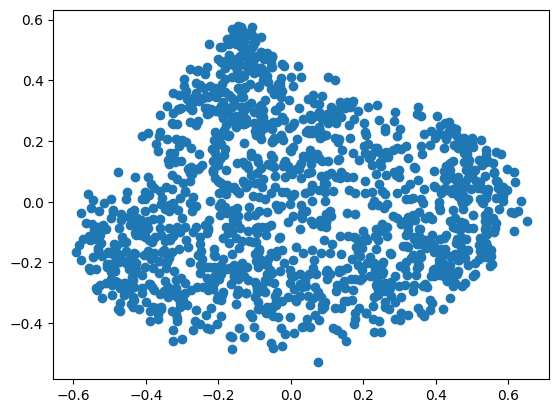

In [31]:
plt.scatter(all_transformed.iloc[:, 0], all_transformed.iloc[:, 1])

In [32]:
OU_df_saved.iloc[0]

drybulb_0        6.619041
drybulb_1      -18.664304
drybulb_2        0.003608
relhum_0        26.044690
relhum_1        41.359542
relhum_2         0.002698
winddir_0      124.709010
winddir_1      -10.468363
winddir_2        0.000406
dirnorrad_0    330.364658
dirnorrad_1   -230.951762
dirnorrad_2      0.000732
windspd_0        3.734412
windspd_1        2.758711
windspd_2        0.000695
Name: 2, dtype: float64

In [33]:
OU_mean

drybulb_0      0.727148
drybulb_1     -1.109914
drybulb_2      0.004124
relhum_0       1.119157
relhum_1       1.393533
relhum_2       0.003260
winddir_0      1.466020
winddir_1     -0.228624
winddir_2      0.000346
dirnorrad_0    0.806109
dirnorrad_1   -0.271036
dirnorrad_2    0.000599
windspd_0      1.469515
windspd_1      0.201109
windspd_2      0.000488
dtype: float64

In [34]:
# sample = np.random.uniform(-0.5, 0, [1, 3])
sample = np.array([[-0.3, -0.3]])
sampled_OU_vars = pca.inverse_transform(sample)
sampled_OU_vars = sampled_OU_vars * np.array(OU_std)[None, -1] + np.array(OU_mean)[None, -1]
store_OU_mean = deepcopy(OU_mean)
store_OU_std = deepcopy(OU_std)
store_OU_min = deepcopy(OU_min)
store_OU_max = deepcopy(OU_max)
store_base_OU = deepcopy(base_OU_params)
for i, column in enumerate(OU_df.columns):
    delim_idx = column.rfind("_")
    var = column[:delim_idx]
    idx = int(column[delim_idx+1:])
    if idx in [0, 1]:
        sampled_OU_vars[:, i] *= df_std[i//3]
        store_OU_mean[i] *= df_std[i//3]
        store_OU_std[i] *= df_std[i//3]
        store_OU_max[i] *= df_std[i//3]
        store_OU_min[i] *= df_std[i//3]


In [35]:
store_OU_mean

drybulb_0        6.546755
drybulb_1       -9.992925
drybulb_2        0.004124
relhum_0        26.616376
relhum_1        33.141739
relhum_2         0.003260
winddir_0      120.533801
winddir_1      -18.797131
winddir_2        0.000346
dirnorrad_0    289.142449
dirnorrad_1    -97.217688
dirnorrad_2      0.000599
windspd_0        2.662246
windspd_1        0.364340
windspd_2        0.000488
dtype: float64

In [36]:
from importlib import reload
import epw_data
from epw_data import EPW_Data
reload(epw_data)

import pickle
epw_data_ = epw_data.EPW_Data(OU_df_saved, all_transformed, pca, store_OU_mean, store_OU_std, store_OU_min, store_OU_max, store_weather_min, store_weather_max, store_base_OU)
epw_data_.save("US_epw_OU_data.pkl")
# with open("US_epw_OU_data.pkl", 'wb') as f:
#     pickle.dump(epw_data_, f)

In [37]:
loaded_data = epw_data.EPW_Data.load("US_epw_OU_data.pkl")

In [38]:
loaded_data.OU_mean

drybulb_0        6.546755
drybulb_1       -9.992925
drybulb_2        0.004124
relhum_0        26.616376
relhum_1        33.141739
relhum_2         0.003260
winddir_0      120.533801
winddir_1      -18.797131
winddir_2        0.000346
dirnorrad_0    289.142449
dirnorrad_1    -97.217688
dirnorrad_2      0.000599
windspd_0        2.662246
windspd_1        0.364340
windspd_2        0.000488
dtype: float64